In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate

In [2]:
params = pd.read_hdf("./image_parameters_smd_train.hdf5")

In [3]:
y = np.concatenate([np.ones(len(params[params.corsika_run_header_particle_id==1])), np.zeros(len(params[params.corsika_run_header_particle_id==14]))])
forbidden_columns = 'ceres_|mc_|corsika_|run_|source_position_|pointing_|aux_|event_num|incident_angle'

params = params.filter(regex=f'^(?!{forbidden_columns}).*$')
X = params
X.head(5)

,concentration_cog,concentration_core,concentration_one_pixel,concentration_two_pixel,leakage1,leakage2,size,width,length,skewness_long,skewness_trans,kurtosis_long,kurtosis_trans,num_islands,num_pixel_in_shower,photoncharge_shower_mean,photoncharge_shower_variance
1,0.586610,0.455474,0.246464,0.455474,0.0,0.0,36.465064,5.008837,8.355993,0.038369,-0.114003,1.747550,1.689157,1,7,5.209295,4.893394
2,0.424287,0.424287,0.178021,0.336471,0.0,0.0,63.775773,5.713048,9.323578,-0.034917,0.117764,1.531659,1.728964,1,9,7.086197,7.917912
5,0.086792,0.464911,0.049563,0.096657,0.0,0.0,2665.858406,9.503945,36.189809,-0.796868,0.164766,3.190828,3.281966,1,100,26.658584,901.313791
6,0.135448,0.356647,0.098123,0.191281,0.0,0.0,208.178530,7.193686,18.298463,0.591534,0.384114,2.375837,2.546314,1,23,9.051240,28.829864
7,0.640389,0.378509,0.261880,0.478792,0.0,0.0,26.615000,5.738275,7.390484,0.608018,-0.379429,1.691941,2.031471,1,5,5.323000,1.362421


In [4]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2)

In [5]:
compare = []
for i in range(X.shape[1]):
    compare = np.append(compare, np.abs(X.values[:,i][y==1].mean() - X.values[:,i][y==0].mean())**2/(X.values[:,i][y==1].std()**2 + X.values[:,i][y==0].std()**2))
index = np.argpartition(compare, -5)[:-5]

In [6]:
X_test = X_test[X_test.columns.difference(X_test.keys()[index])]
X_train = X_train[X_train.columns.difference(X_train.keys()[index])]

In [7]:
rf1 = RandomForestClassifier(n_estimators=1, min_samples_leaf=5, n_jobs=-1)
rf10 = RandomForestClassifier(n_estimators=10, min_samples_leaf=5, n_jobs=-1)
rf100 = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, n_jobs=-1)

score = cross_validate(rf1, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=1   {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
score = cross_validate(rf10, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=10  {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))
score = cross_validate(rf100, X_train, y_train, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest n=100 {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

ROC AUC Random Forest n=1   0.571 +/- 0.003
ROC AUC Random Forest n=10  0.612 +/- 0.009
ROC AUC Random Forest n=100 0.618 +/- 0.011


In [8]:
rf100.fit(X_train, y_train)
y_prediction_proba = rf100.predict_proba(X_test)

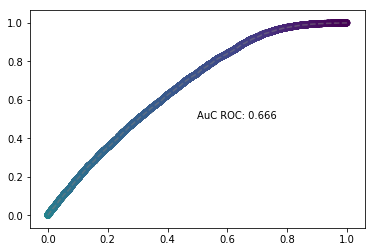

In [9]:
auc = roc_auc_score(y_test, y_prediction_proba[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_proba[:, 1])
plt.scatter(fpr, tpr, c=thresholds)
plt.plot(fpr, tpr, '--', color='gray', alpha=0.5)
plt.text(0.5, 0.5, f'AuC ROC: {auc:0.03f}')
None

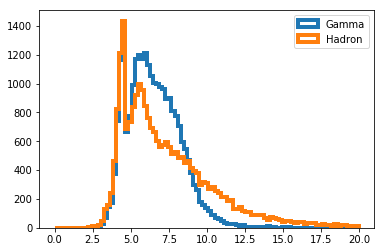

In [11]:
bins = np.linspace(0, 20, 100)
plt.hist(X[y==1].width, bins=bins, histtype='step', lw=4, label="Gamma")
plt.hist(X[y==0].width, bins=bins, histtype='step', lw=4, label="Hadron")
plt.legend(loc="best")
None